In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from collections import Counter
import plotly.express as px

import nltk
import re


from wordcloud import WordCloud, STOPWORDS
import string

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/website_classification.csv')

In [ ]:
df.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [ ]:
df = df.drop(['Unnamed: 0', 'website_url'], axis=1)

In [ ]:
df.head()

,cleaned_website_text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel


In [ ]:
import pandas as pd
import re

def keep_english(text):
    english_words = re.findall(r'\b[a-zA-Z]+\b', text)
    return ' '.join(english_words)

df['cleaned_website_text'] = df['cleaned_website_text'].apply(keep_english)


In [ ]:
df.head()

,cleaned_website_text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel


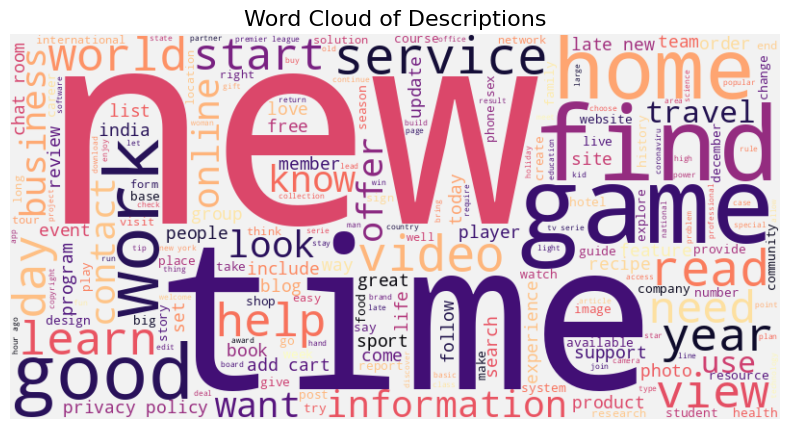

In [ ]:
# Display wordcloud for the most frequent words
def cloud(word, title, colormap='viridis', background_color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=background_color, colormap=colormap, random_state=42).generate(word)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

all_descriptions = ' '.join(df['cleaned_website_text'].values)
cloud(all_descriptions, "Word Cloud of Descriptions", colormap='magma', background_color='#f2f2f2')

In [ ]:
word_counter = Counter(' '.join(df['cleaned_website_text']).split())

# Top 200 words
top_words = dict(word_counter.most_common(100))
df_top_words = pd.DataFrame(list(top_words.items()), columns=['Word', 'Frequency'])

# Treemap
fig = px.treemap(df_top_words, path=['Word'], values='Frequency', width=1200, height=700,
                 color_continuous_midpoint=0.5, color_continuous_scale='viridis',
                 title='Top 200 Most Frequent Words in Dataset',
                 labels={'Frequency': 'Frequency', 'Word': 'Word'})

fig.update_layout(title_x=0.5, title_font=dict(size=20), font_family='Arial',
                  margin=dict(t=100, b=0, l=0, r=0))

fig.update_traces(textinfo="label+value")
fig.show()


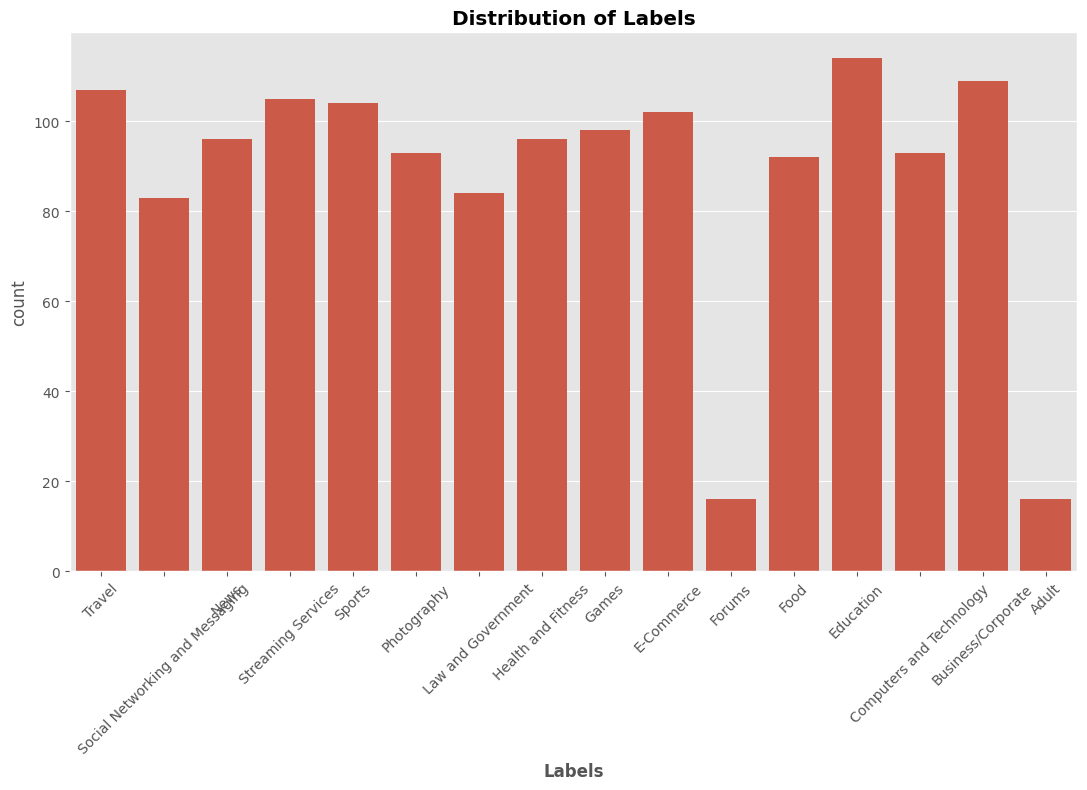

In [ ]:
plt.figure(figsize=(13, 7))
plt.style.use('ggplot')
sns.countplot(x='Category', data=df)
plt.title('Distribution of Labels', fontweight='bold')
plt.xlabel('Labels', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

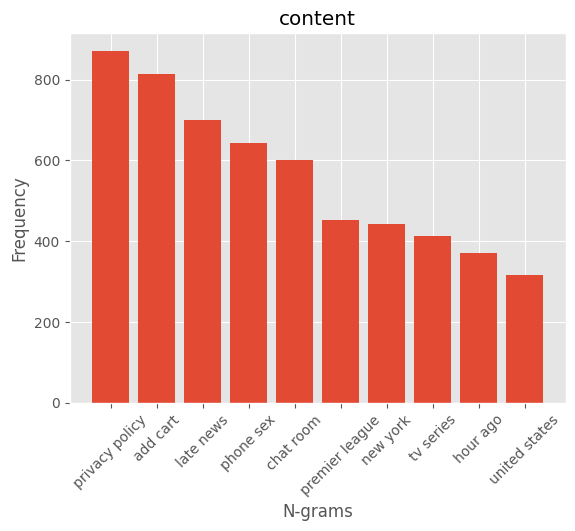

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def plot_top_ngrams(corpus, n, g, text_type):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(tokens, sum_words[0, idx]) for tokens, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    plt.bar([x[0] for x in words_freq], [x[1] for x in words_freq])
    plt.xticks(rotation=45)
    plt.xlabel("N-grams")
    plt.ylabel("Frequency")
    plt.title(f"{text_type}")
    plt.show()

plot_top_ngrams(df['cleaned_website_text'], 10, 2, "content")

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['cleaned_website_text'], df['Category'], test_size=0.2, random_state = 42)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1126,), (282,), (1126,), (282,))

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.8581560283687943

Classification Report:
                                 precision    recall  f1-score   support

                          Adult       0.00      0.00      0.00         4
             Business/Corporate       0.62      0.88      0.73        17
       Computers and Technology       0.82      0.47      0.60        19
                     E-Commerce       0.95      0.91      0.93        22
                      Education       0.81      0.93      0.86        27
                           Food       0.88      0.88      0.88        17
                         Forums       0.00      0.00      0.00         2
                          Games       1.00      0.82      0.90        22
             Health and Fitness       1.00      1.00      1.00        13
             Law and Government       1.00      0.91      0.95        23
                           News       0.68      0.94      0.79        18
                    Photography       0.95      0.90      0.92        

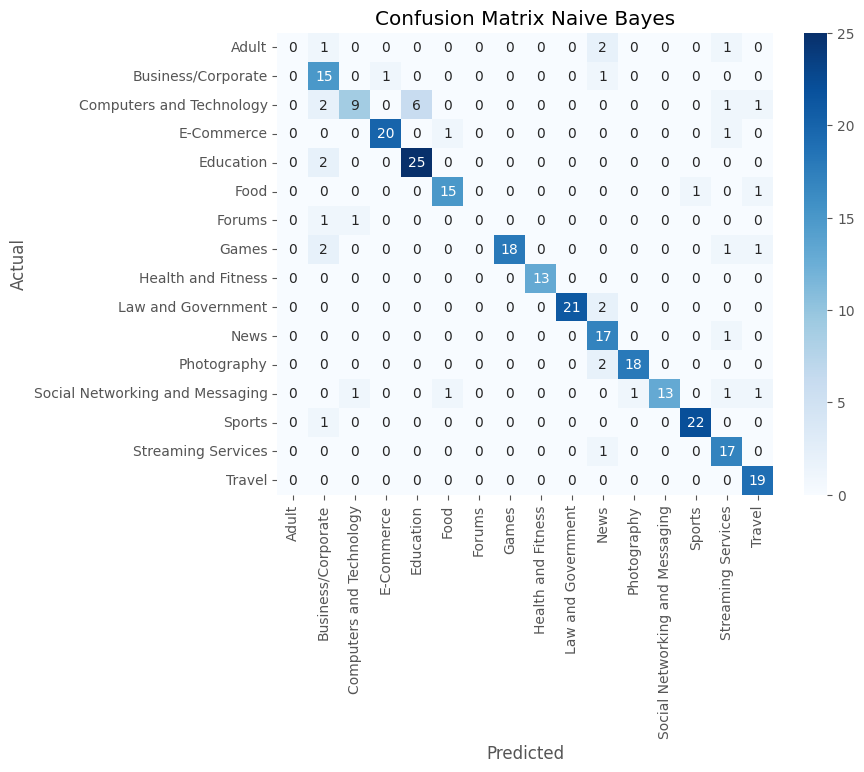

In [ ]:
# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:

from sklearn.model_selection import GridSearchCV

nb_grid = {
    'clf__alpha': [0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
    'clf__class_prior': [None]
}
grid_search = GridSearchCV(nb, param_grid=nb_grid, cv=5, verbose=2)

grid_search.fit(x_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

best_nb = grid_search.best_estimator_
y_pred_best_nb = best_nb.predict(x_test)
print('\nAccuracy:', accuracy_score(y_test, y_pred_best_nb))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_best_nb))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=True; total time=   0.8s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=True; total time=   0.8s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=True; total time=   0.8s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=True; total time=   0.8s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=True; total time=   0.8s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=False; total time=   0.8s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=False; total time=   0.9s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=False; total time=   0.8s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=False; total time=   0.8s
[CV] END clf__alpha=0.1, clf__class_prior=None, clf__fit_prior=False; total time=   1.3s
[CV] END clf__alpha=0.5, clf__class_prior=None, clf__fi

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

dt = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())
])

dt.fit(x_train, y_train)

y_pred_dt = dt.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred_dt))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_dt))


Accuracy: 0.6099290780141844

Classification Report:
                                 precision    recall  f1-score   support

                          Adult       1.00      0.25      0.40         4
             Business/Corporate       0.29      0.29      0.29        17
       Computers and Technology       0.33      0.47      0.39        19
                     E-Commerce       0.94      0.73      0.82        22
                      Education       0.50      0.44      0.47        27
                           Food       0.77      0.59      0.67        17
                         Forums       0.00      0.00      0.00         2
                          Games       0.60      0.55      0.57        22
             Health and Fitness       0.78      0.54      0.64        13
             Law and Government       0.68      0.57      0.62        23
                           News       0.60      0.67      0.63        18
                    Photography       0.55      0.90      0.68        

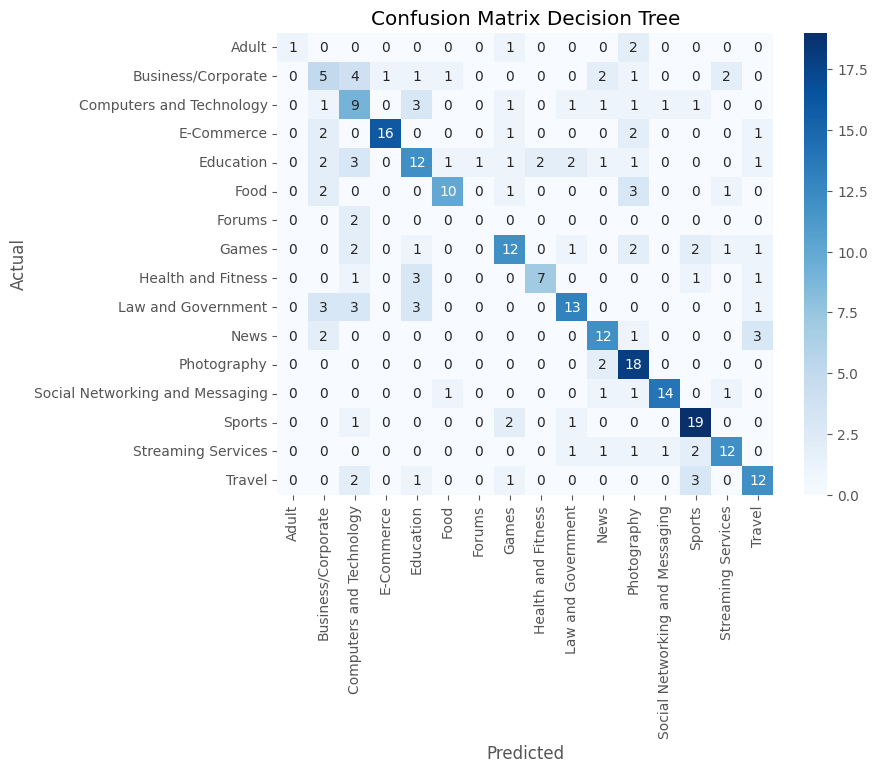

In [ ]:
# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
dt_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dt, param_grid=dt_grid, cv=3, verbose=2)

grid_search.fit(x_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

best_dt = grid_search.best_estimator_

y_pred_best_dt = best_dt.predict(x_test)

print('\nAccuracy:', accuracy_score(y_test, y_pred_best_dt))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_best_dt))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   1.5s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   2.0s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2; total time=   2.4s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=5; total time=   1.6s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=5; total time=   1.5s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=5; total time=   1.4s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=10; total time=   1.4s
[CV] END clf__criterion=gini, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_sampl

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

rf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])

rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.8226950354609929

Classification Report:
                                 precision    recall  f1-score   support

                          Adult       1.00      0.25      0.40         4
             Business/Corporate       0.55      0.71      0.62        17
       Computers and Technology       0.73      0.58      0.65        19
                     E-Commerce       0.86      0.86      0.86        22
                      Education       0.83      0.74      0.78        27
                           Food       0.79      0.88      0.83        17
                         Forums       0.00      0.00      0.00         2
                          Games       0.85      0.77      0.81        22
             Health and Fitness       0.92      0.85      0.88        13
             Law and Government       1.00      0.91      0.95        23
                           News       0.84      0.89      0.86        18
                    Photography       0.54      0.95      0.69        

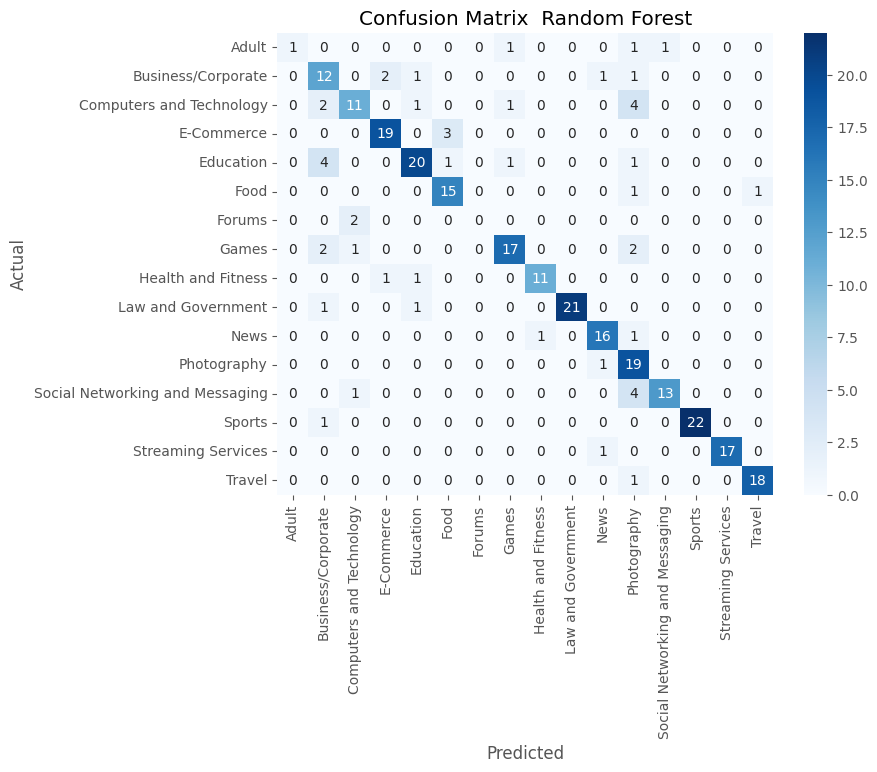

In [ ]:
# Confusion Matrix for Random Forest
cm_rf= confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix  Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
rf_grid = {
    'clf__n_estimators': [100, 200, 300],        # Số lượng cây
    'clf__max_depth': [10, 20, 30, None],         # Độ sâu tối đa của các cây
    'clf__min_samples_split': [2, 5, 10],         # Số lượng mẫu tối thiểu cần để phân chia một nút
    'clf__min_samples_leaf': [1, 2, 4],           # Số lượng mẫu tối thiểu cần để hiển thị ở lá
}

grid_search = GridSearchCV(rf, param_grid=rf_grid, cv=3, verbose=2)

grid_search.fit(x_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(x_test)

print('\nAccuracy:', accuracy_score(y_test, y_pred_best_rf))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_best_rf))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.3s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.3s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   1.2s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.8s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.8s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   1.7s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   3.5s
[CV] END clf__max_depth=10, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_esti

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

knn = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier())
])

knn.fit(x_train, y_train)

y_pred_knn = knn.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred_knn))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_knn))


Accuracy: 0.8829787234042553

Classification Report:
                                 precision    recall  f1-score   support

                          Adult       1.00      0.75      0.86         4
             Business/Corporate       0.88      0.82      0.85        17
       Computers and Technology       0.76      0.84      0.80        19
                     E-Commerce       0.91      0.91      0.91        22
                      Education       1.00      0.93      0.96        27
                           Food       0.88      0.88      0.88        17
                         Forums       0.00      0.00      0.00         2
                          Games       1.00      0.86      0.93        22
             Health and Fitness       0.93      1.00      0.96        13
             Law and Government       0.88      0.96      0.92        23
                           News       0.88      0.78      0.82        18
                    Photography       0.68      0.95      0.79        

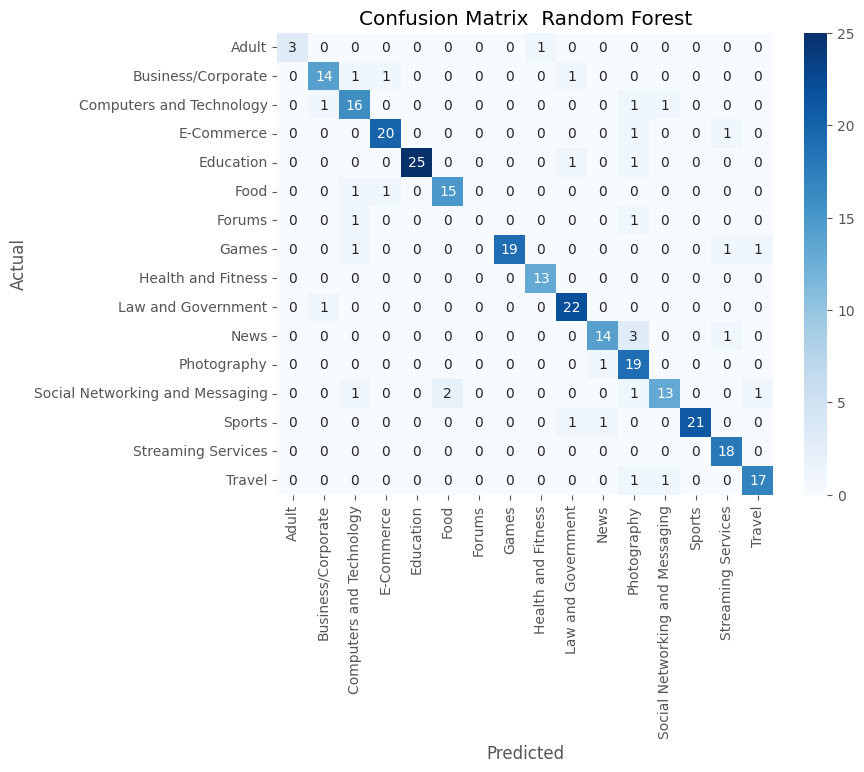

In [ ]:
# Confusion Matrix for KNN
cm_knn= confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix  Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline


knn_grid = {
    'clf__n_neighbors': [5, 10, 15],        # Số lượng láng giềng sử dụng cho phân loại
    'clf__weights': ['uniform', 'distance'], # Phương pháp tính trọng số
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Thuật toán tính toán
}

grid_search = GridSearchCV(knn, param_grid=knn_grid, cv=3, verbose=2)

grid_search.fit(x_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

best_knn = grid_search.best_estimator_

y_pred_best_knn = best_knn.predict(x_test)

print('\nAccuracy:', accuracy_score(y_test, y_pred_best_knn))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_best_knn))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END clf__algorithm=auto, clf__n_neighbors=5, clf__weights=uniform; total time=  22.2s
[CV] END clf__algorithm=auto, clf__n_neighbors=5, clf__weights=uniform; total time=  21.1s
[CV] END clf__algorithm=auto, clf__n_neighbors=5, clf__weights=uniform; total time=  22.4s
[CV] END clf__algorithm=auto, clf__n_neighbors=5, clf__weights=distance; total time=  21.0s
[CV] END clf__algorithm=auto, clf__n_neighbors=5, clf__weights=distance; total time=  23.5s
[CV] END clf__algorithm=auto, clf__n_neighbors=5, clf__weights=distance; total time=  20.5s
[CV] END clf__algorithm=auto, clf__n_neighbors=10, clf__weights=uniform; total time=  22.8s
[CV] END clf__algorithm=auto, clf__n_neighbors=10, clf__weights=uniform; total time=  21.5s
[CV] END clf__algorithm=auto, clf__n_neighbors=10, clf__weights=uniform; total time=  22.4s
[CV] END clf__algorithm=auto, clf__n_neighbors=10, clf__weights=distance; total time=  20.9s
[CV] END clf__algorit